In [9]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from utils import *
from irt import *

data_path = '/llmthonskdir/felipe/download_openllmlb/'
device='cuda:0'

In [20]:
def logit(x, eps=.001):
    c = np.min(x)
    x2 = (np.array(x)-c)/(1-c)
    return np.log((1+x2+eps)/(1-x2+eps))

In [2]:
with open(data_path+'scaling_laws/old_leaderboard_processed_20240630.pickle', 'rb') as handle:
    lb_data = pickle.load(handle)

In [3]:
mmlu_subs = ['hendrycksTest-abstract_algebra', 'hendrycksTest-anatomy', 'hendrycksTest-astronomy', 'hendrycksTest-business_ethics',
             'hendrycksTest-clinical_knowledge', 'hendrycksTest-college_biology', 'hendrycksTest-college_chemistry',
             'hendrycksTest-college_computer_science', 'hendrycksTest-college_mathematics', 'hendrycksTest-college_medicine', 'hendrycksTest-college_physics', 'hendrycksTest-computer_security', 'hendrycksTest-conceptual_physics', 'hendrycksTest-econometrics', 'hendrycksTest-electrical_engineering', 'hendrycksTest-elementary_mathematics', 'hendrycksTest-formal_logic', 'hendrycksTest-global_facts', 'hendrycksTest-high_school_biology', 'hendrycksTest-high_school_chemistry', 'hendrycksTest-high_school_computer_science', 'hendrycksTest-high_school_european_history', 'hendrycksTest-high_school_geography', 'hendrycksTest-high_school_government_and_politics', 'hendrycksTest-high_school_macroeconomics', 'hendrycksTest-high_school_mathematics', 'hendrycksTest-high_school_microeconomics', 'hendrycksTest-high_school_physics', 'hendrycksTest-high_school_psychology', 'hendrycksTest-high_school_statistics', 'hendrycksTest-high_school_us_history', 'hendrycksTest-high_school_world_history', 'hendrycksTest-human_aging', 'hendrycksTest-human_sexuality', 'hendrycksTest-international_law', 'hendrycksTest-jurisprudence', 'hendrycksTest-logical_fallacies', 'hendrycksTest-machine_learning', 'hendrycksTest-management', 'hendrycksTest-marketing', 'hendrycksTest-medical_genetics', 'hendrycksTest-miscellaneous', 'hendrycksTest-moral_disputes', 'hendrycksTest-moral_scenarios', 'hendrycksTest-nutrition', 'hendrycksTest-philosophy', 'hendrycksTest-prehistory', 'hendrycksTest-professional_accounting', 'hendrycksTest-professional_law', 'hendrycksTest-professional_medicine', 'hendrycksTest-professional_psychology', 'hendrycksTest-public_relations', 'hendrycksTest-security_studies', 'hendrycksTest-sociology', 'hendrycksTest-us_foreign_policy', 'hendrycksTest-virology', 'hendrycksTest-world_religions']
mmlu_posics = [0]+np.cumsum([lb_data[s]['correctness'].shape[1] for s in mmlu_subs]).tolist()
mmlu_posics = [list(range(mmlu_posics[i],mmlu_posics[i+1],1)) for i in range(len(mmlu_posics)-1)]
lb_data['mmlu'] = {'correctness': np.hstack([lb_data[s]['correctness'] for s in mmlu_subs]), 'models':lb_data['hendrycksTest-abstract_algebra']['models']}
scenarios = ['mmlu', 'arc:challenge', 'gsm8k', 'hellaswag', 'truthfulqa:mc', 'winogrande']

In [4]:
results = {}

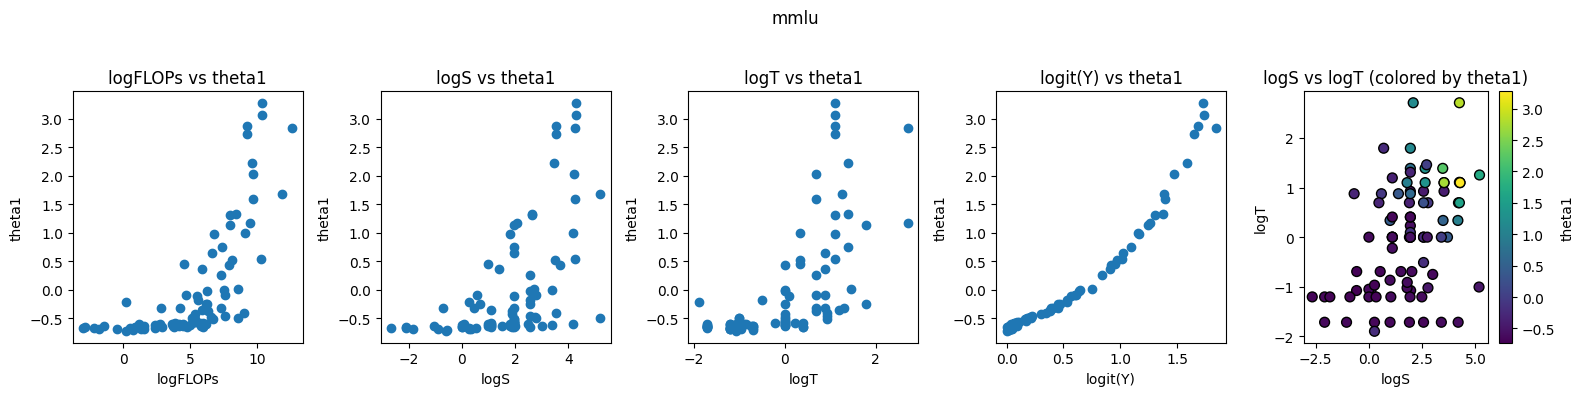

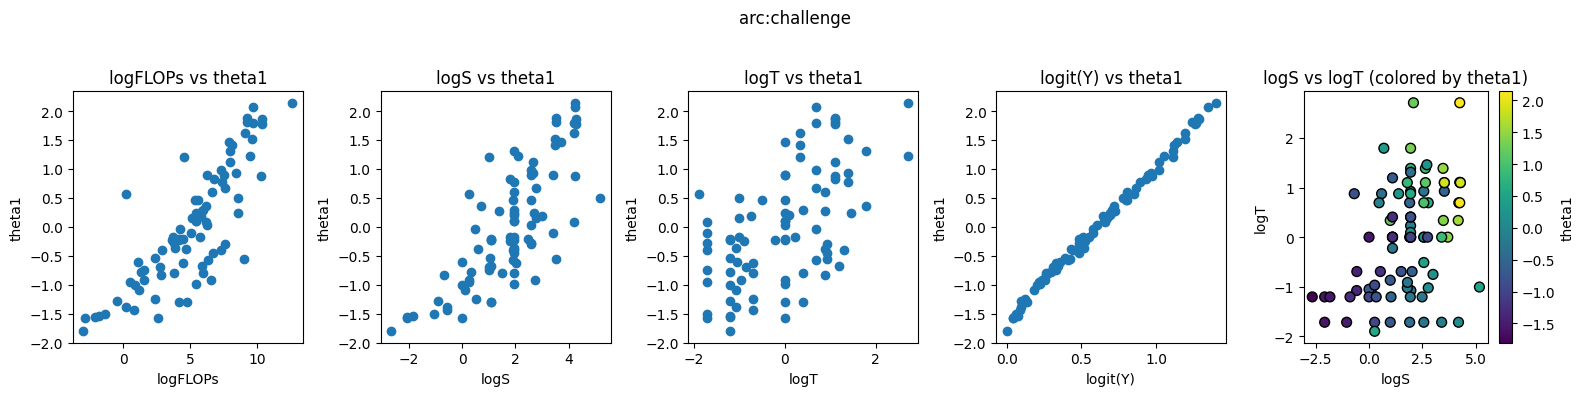

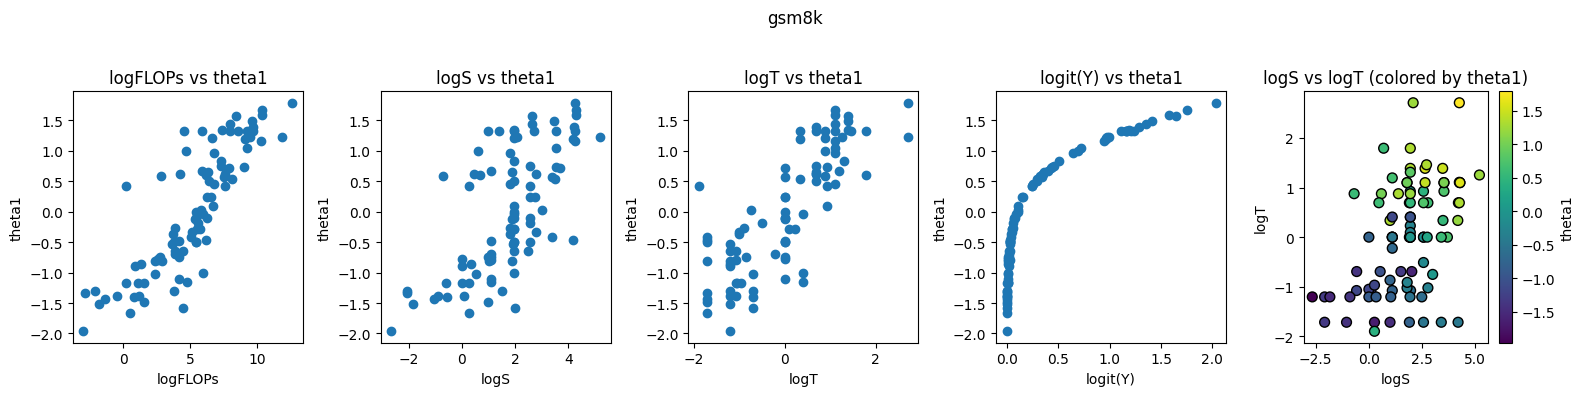

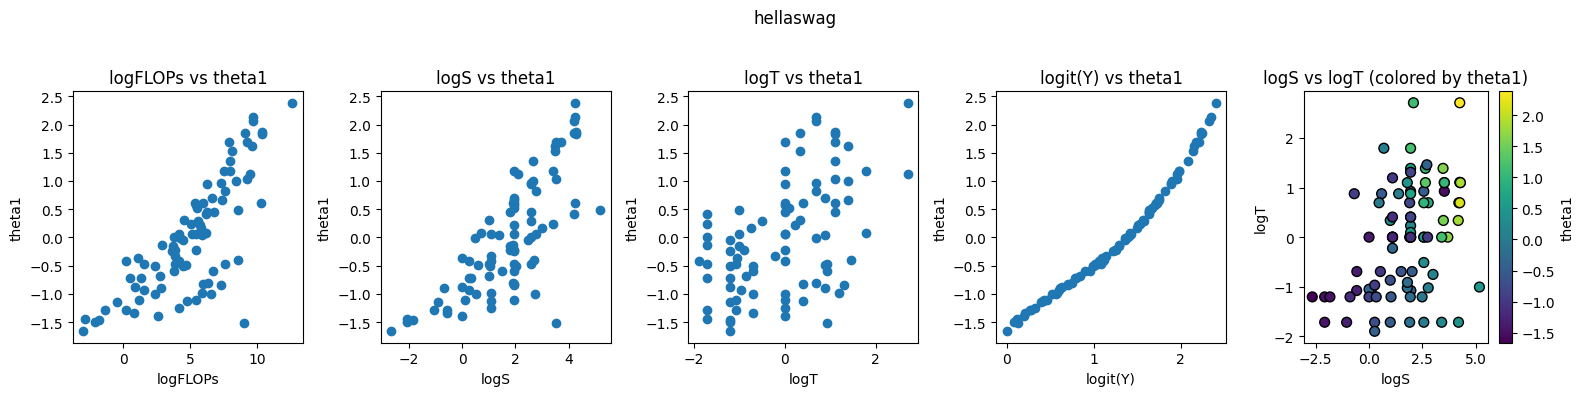

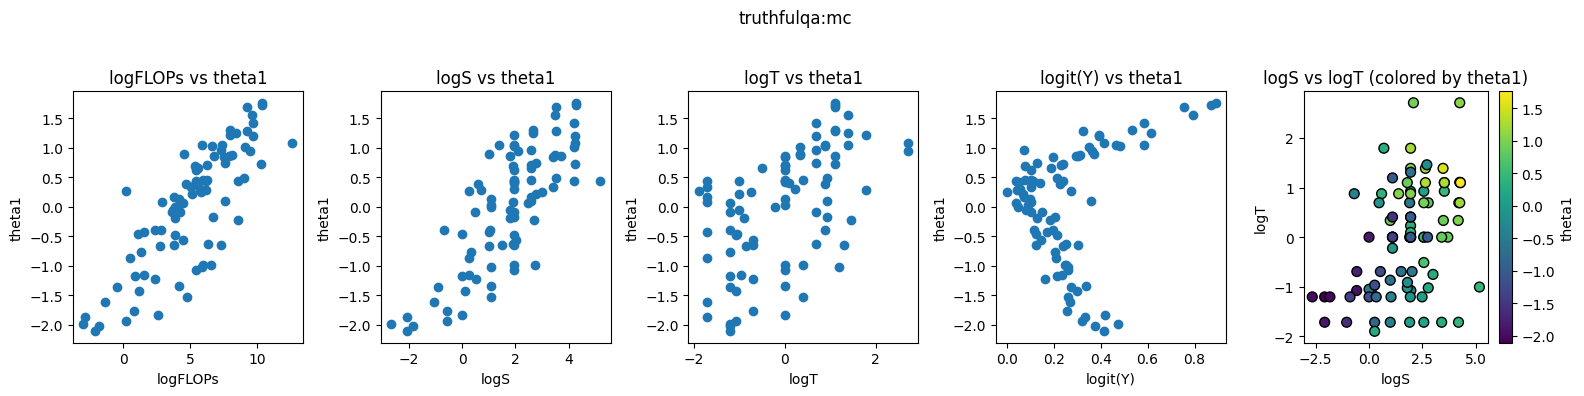

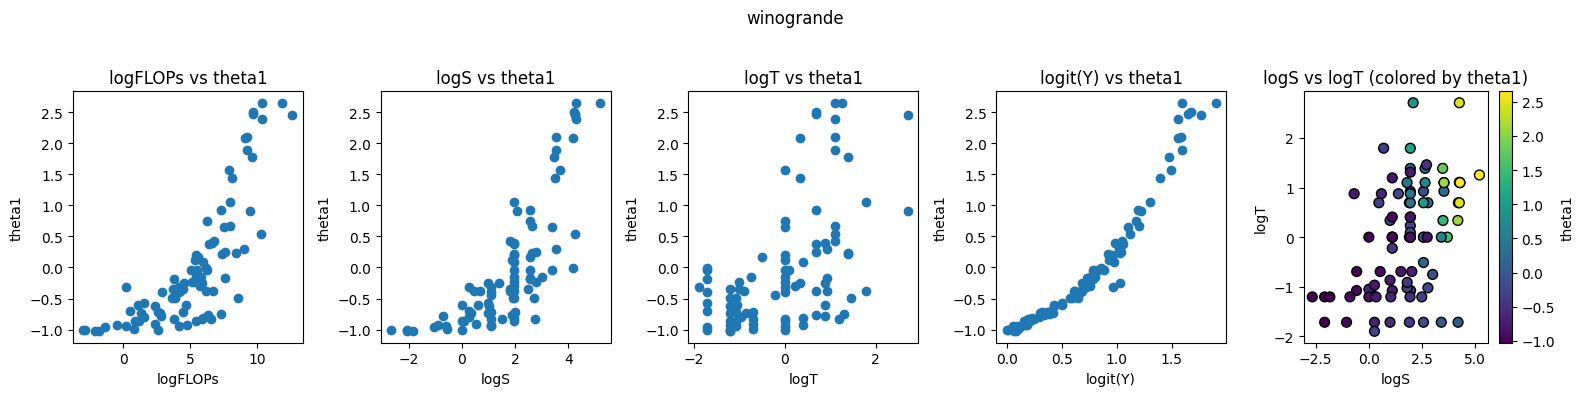

In [33]:
for scenario in scenarios:
    results[scenario] = {}
    
    scaling_data = pd.read_csv(data_path+'scaling_laws/base_llm_benchmark_eval.csv')
    
    ###
    if scenario=='mmlu':
        models_lb = lb_data['hendrycksTest-abstract_algebra']['models']
    else:
        models_lb = lb_data[scenario]['models'] #any scenario would work
        
    models_lb = [filter(m) for m in models_lb]
    models_scaling = list(scaling_data.Model)
    models_scaling = [filter(m) for m in models_scaling]
    scaling_data = scaling_data.loc[[m in models_lb for m in models_scaling]]
    scaling_data['logFLOPs'] = np.log2(scaling_data.loc[:,['FLOPs (1E21)']])
    scaling_data = scaling_data.loc[:,['Model','Model Family', 'logFLOPs', 'Model Size (B)', 'Pretraining Data Size (T)']]
    scaling_data = scaling_data.rename(columns={'Model':'model', 'Model Family': "family", 'Model Size (B)':'size', 'Pretraining Data Size (T)':'tokens'})
    scaling_data = scaling_data.sort_values(by=['family', 'logFLOPs']).reset_index(drop=True)
    scaling_data = scaling_data.loc[~np.array(np.isnan(scaling_data.loc[:,['logFLOPs']])).squeeze()]
    models_scaling = list(scaling_data.model)
    models_scaling = [filter(m) for m in models_scaling]
    
    assert np.mean([np.sum(np.array(models_lb)==m) for m in models_scaling])==1 #checking if we find all models
    if scenario=='mmlu':
        Y = [lb_data[scenario]['correctness'][[np.argmax(np.array(models_lb)==m) for m in models_scaling]] for scenario in mmlu_subs]
        Y = np.hstack(Y)
        acc = [lb_data[scenario]['correctness'][[np.argmax(np.array(models_lb)==m) for m in models_scaling]].mean(1) for scenario in mmlu_subs]
        acc = np.vstack(acc).T.mean(1)
    else:
        Y = lb_data[scenario]['correctness'][[np.argmax(np.array(models_lb)==m) for m in models_scaling]]
        acc = Y.mean(1)
        
    irt1 = IRT(ds=[1], model = 'm2pl', device='cpu')
    irt1.fit(Y, verbose=False, random_seed=42)
    irt2 = IRT(ds=[2], model = 'm2pl', device='cpu')
    irt2.fit(Y, verbose=False, random_seed=42)
    results[scenario] = {'family':scaling_data.family,
                         'logFLOPs':np.array(scaling_data.logFLOPs),
                         'logS':np.log(np.array(scaling_data['size'])),
                         'logT':np.log(np.array(scaling_data.tokens)),
                         'theta1':irt1.Theta.squeeze(),
                         'theta21':irt2.Theta.squeeze()[:,0],
                         'theta22':irt2.Theta.squeeze()[:,1],
                         'logit_y':logit(acc)}
    
    # Assuming 'results' and 'scenario' are defined
    df = pd.DataFrame(results[scenario])
    fig, axs = plt.subplots(1, 5, figsize=(16, 4))
    # First scatter plot
    axs[0].scatter(df.logFLOPs, df.theta1)
    axs[0].set_title('logFLOPs vs theta1')
    axs[0].set_xlabel('logFLOPs')
    axs[0].set_ylabel('theta1')
    # Second scatter plot
    axs[1].scatter(df.logS, df.theta1)
    axs[1].set_title('logS vs theta1')
    axs[1].set_xlabel('logS')
    axs[1].set_ylabel('theta1')
    # Third scatter plot
    axs[2].scatter(df.logT, df.theta1)
    axs[2].set_title('logT vs theta1')
    axs[2].set_xlabel('logT')
    axs[2].set_ylabel('theta1')
    axs[3].scatter(df.logit_y, df.theta1)
    axs[3].set_title('logit(Y) vs theta1')
    axs[3].set_xlabel('logit(Y)')
    axs[3].set_ylabel('theta1')
    # Fourth scatter plot
    scatter = axs[4].scatter(df.logS, df.logT, c=df.theta1, cmap='viridis', s=50, edgecolor='k')
    cbar = fig.colorbar(scatter, ax=axs[4])
    cbar.set_label('theta1')
    axs[4].set_title('logS vs logT (colored by theta1)')
    axs[4].set_xlabel('logS')
    axs[4].set_ylabel('logT')
    # Add a title for the entire row
    plt.suptitle(f'{scenario}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

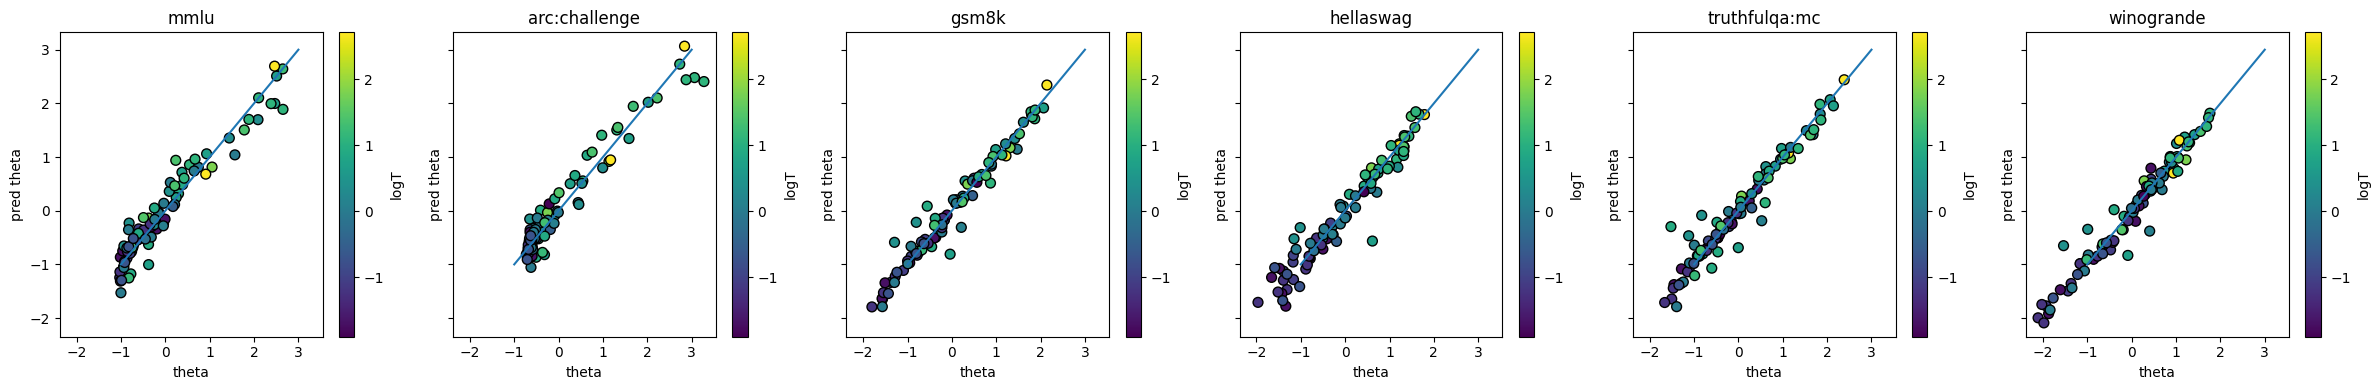

In [30]:
# Number of subplots needed
n_rows = 1
n_cols = 6

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4), sharex=True, sharey=True)

# Flatten the 2D array of axes to iterate easily
axes = axes.flatten()

regs=[]
for i, bench in enumerate(scenarios):
    df = pd.DataFrame(results[scenario])
    scenario = bench
    logS = df.logS
    logT = df.logT
    y = df.theta1
    select = (~np.isnan(logS))*(~np.isnan(logT))*(~np.isnan(y))
    logS = logS[select]
    logT = logT[select]
    y = y[select]
    D = np.array(pd.get_dummies(df['family'])).astype(int)[select]
    
    # Fit linear regression model
    X = np.column_stack([logS, logT, logS*logT, D])
    regs.append(LinearRegression(fit_intercept=False))
    regs[-1].fit(X, y)
    
    # Predict and compute residuals
    y_pred = regs[-1].predict(X)
    residuals = y - y_pred

    # Plot residuals vs predicted y
    scatter = axes[i].scatter(y, y_pred,c=logT, cmap='viridis', s=50, edgecolor='k')
    axes[i].plot([-1,3],[-1,3])
    # Add color bar to show the scale
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label('logT')
    
    # Add labels and title
    axes[i].set_xlabel('theta')
    axes[i].set_ylabel('pred theta')
    axes[i].set_title(f'{bench}')

# Remove any unused subplots
for j in range(len(scenarios), n_rows * n_cols):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()